This notebook is based on the file [MNIST Digit Classification programming exercise](https://colab.research.google.com/notebooks/mlcc/multi-class_classification_of_handwritten_digits.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=multiclass-colab&hl=en), which is part of Google's [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classifying Handwritten Digits with Neural Networks

![img](https://www.tensorflow.org/versions/r0.11/images/MNIST.png)

**Learning Objectives:**
  * Train both a linear model and a neural network to classify handwritten digits from the classic [MNIST](http://yann.lecun.com/exdb/mnist/) data set
  * Compare the performance of the linear and neural network classification models
  * Visualize the weights of a neural-network hidden layer

Our goal is to map each input image to the correct numeric digit. We will create a NN with a few hidden layers and a Softmax layer at the top to select the winning class.

## Setup

First, let's load the data set, import TensorFlow and other utilities, and load the data into a `DataFrame`. Note that this data is a sample of the original MNIST training data.

In [2]:
using Plots
using Distributions
gr(fmt=:png)
using DataFrames
using TensorFlow
import CSV
import StatsBase
using PyCall
sklm=pyimport("sklearn.metrics")
using Images
using Colors
using Random
using Statistics

sess=Session(Graph())

2019-03-06 20:07:00.299635: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


Session(Ptr{Nothing} @0x0000000109142f10)

We use the ``MNIST.jl`` package for accessing the dataset. The functions for loading the data and creating batches follow its [documentation](https://github.com/johnmyleswhite/MNIST.jl). Please note this package does not seem to be actively maintained at the moment. In order to work with Julia 1.1, ``MNIST.jl`` requires some patches. An updated file can be found [here](https://github.com/sdobber/MLCrashCourse/blob/master/MNIST.jl).

In [25]:
using MNIST

mutable struct DataLoader
    cur_id::Int
    order::Vector{Int}
end

DataLoader() = DataLoader(1, shuffle(1:60000))
loader=DataLoader()

function next_batch(loader::DataLoader, batch_size)
    features = zeros(Float32, batch_size, 784)
    labels = zeros(Float32, batch_size, 10)
    for i in 1:batch_size
        features[i, :] = trainfeatures(loader.order[loader.cur_id])./255.0
        label = trainlabel(loader.order[loader.cur_id])
        labels[i, Int(label)+1] = 1.0
        loader.cur_id += 1
        if loader.cur_id > 60000
            loader.cur_id = 1
        end
    end
    features, labels
end

function load_test_set(N=10000)
    features = zeros(Float32, N, 784)
    labels = zeros(Float32, N, 10)
    for i in 1:N
        features[i, :] = testfeatures(i)./255.0
        label = testlabel(i)
        labels[i, Int(label)+1] = 1.0
    end
    features,labels
end

load_test_set (generic function with 2 methods)

``labels`` represents the label that a human rater has assigned for one handwritten digit. The ten digits 0-9 are each represented, with a unique class label for each possible digit. Thus, this is a multi-class classification problem with 10 classes.

![img](https://www.tensorflow.org/versions/r0.11/images/MNIST-Matrix.png)

The variable ``features`` contains the feature values, one per pixel for the 28×28=784 pixel values. The pixel values are on a gray scale in which 0 represents white, 255 represents black, and values between 0 and 255 represent shades of gray. Most of the pixel values are 0; you may want to take a minute to confirm that they aren't all 0.  For example, adjust the following text block to print out the features and labels for dataset 72.

In [4]:
trainfeatures(72)

784-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [5]:
trainlabel(72)

7.0

Now, let's parse out the labels and features and look at a few examples. Show a random example and its corresponding label:

┌ Warning: gray is found in more than one library: cmocean, colorcet. Choosing cmocean
└ @ PlotUtils /Users/sdobber/.julia/packages/PlotUtils/GxT73/src/color_gradients.jl:40


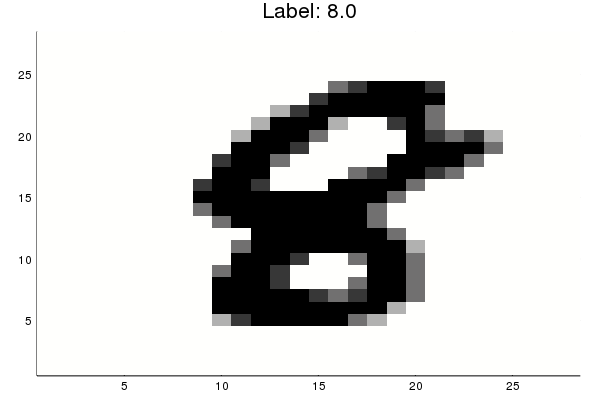

In [6]:
rand_number=rand(1:60000)
rand_example_features = trainfeatures(rand_number)
rand_example_label=trainlabel(rand_number)
#img=colorview(Gray,1 .-reshape(rand_example_features, (28, 28)))
#println("Label: ",rand_example_label)
#img
p1=heatmap(reverse(1 .-reshape(rand_example_features, (28, 28)),dims=1), legend=:none, c=:gray, title="Label: $rand_example_label")

The following functions normalize the features and convert the targets to a one-hot encoding. For example, if the variable contains '1' in column 5, then a human rater interpreted the handwritten character as the digit '6'.

In [7]:
function preprocess_features(data_range)
    examples = zeros(Float32, length(data_range), 784)
    for i in 1:length(data_range)
        examples[i, :] = testfeatures(i)./255.0
    end
    return examples
end


function preprocess_targets(data_range)
    targets = zeros(Float32, length(data_range), 10)
    for i in 1:length(data_range)
        label = testlabel(i)
        targets[i, Int(label)+1] = 1.0
    end
    return targets
end

preprocess_targets (generic function with 1 method)

Let's devide the first 10000 datasets into training and validation examples.

In [8]:
training_examples = preprocess_features(1:7500)
training_targets = preprocess_targets(1:7500)

validation_examples=preprocess_features(7501:10000)
validation_targets=preprocess_targets(7501:10000);

The following function converts the predicted labels (in one-hot encoding) back to a numerical label from 0 to 9.

In [9]:
function to1col(targets)
    reduced_targets=zeros(size(targets,1),1)
    for i=1:size(targets,1)
        reduced_targets[i]=sum( collect(0:size(targets,2)-1).*targets[i,:])  
    end
    return reduced_targets
end

to1col (generic function with 1 method)

## Task 1: Build a Linear Model for MNIST

First, let's create a baseline model to compare against. You'll notice that in addition to reporting accuracy, and plotting Log Loss over time, we also display a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix).  The confusion matrix shows which classes were misclassified as other classes. Which digits get confused for each other? Also note that we track the model's error using the `log_loss` function. 

In [10]:
function train_linear_classification_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets)
  """Trains a linear classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, and a confusion
  matrix.
  
  Args:
    learning_rate: An `int`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: An `Array` containing the training features.
    training_targets: An `Array` containing the training labels.
    validation_examples: An `Array` containing the validation features.
    validation_targets: An `Array` containing the validation labels.
      
  Returns:
    p1: Plot of loss metrics
    p2: Plot of confusion matrix
  """

  periods = 10

  steps_per_period = steps / periods  
  
  # Create feature columns
  feature_columns = placeholder(Float32)
  target_columns = placeholder(Float32)
    
  # Create network
  W = Variable(zeros(Float32, 784, 10))
  b = Variable(zeros(Float32, 10)) 
  
  y = nn.softmax(feature_columns*W + b)
  cross_entropy = reduce_mean(-reduce_sum(target_columns .* log(y), axis=[2]))
    
  # Gradient decent with gradient clipping
  my_optimizer=(train.AdamOptimizer(learning_rate))
  gvs = train.compute_gradients(my_optimizer, cross_entropy)
  capped_gvs = [(clip_by_norm(grad, 5.), var) for (grad, var) in gvs]
  my_optimizer = train.apply_gradients(my_optimizer,capped_gvs)
    
  run(sess, global_variables_initializer())

    
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  println("Training model...")
  println("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in 1:periods
    for i=1:steps_per_period
        
    # Train the model, starting from the prior state.
    features_batches, targets_batches = next_batch(loader, batch_size)
    run(sess, my_optimizer, Dict(feature_columns=>features_batches, target_columns=>targets_batches))    
    end
  
    # Take a break and compute probabilities.
    training_predictions = run(sess, y, Dict(feature_columns=> training_examples, target_columns=>training_targets)) 
    validation_predictions = run(sess, y, Dict(feature_columns=> validation_examples, target_columns=>validation_targets))
    
    # Compute training and validation errors.
    training_log_loss = sklm.log_loss(training_targets, training_predictions)
    validation_log_loss = sklm.log_loss(validation_targets, validation_predictions)
    # Occasionally print the current loss.
    println("  period ", period, ": ",validation_log_loss)
    # Add the loss metrics from this period to our list.
    push!(training_errors, training_log_loss)
    push!(validation_errors, validation_log_loss)
  end      
        
        
  println("Model training finished.")
  
  # Calculate final predictions (not probabilities, as above).
  final_probabilities = run(sess, y, Dict(feature_columns=> validation_examples, target_columns=>validation_targets))
  
  final_predictions=0.0.*copy(final_probabilities)
  for i=1:size(final_predictions,1)
        final_predictions[i,argmax(final_probabilities[i,:])]=1.0
  end
  
  accuracy = sklm.accuracy_score(validation_targets, final_predictions)
  println("Final accuracy (on validation data): ", accuracy)

  # Output a graph of loss metrics over periods.
  p1=plot(training_errors, label="training", title="LogLoss vs. Periods", ylabel="LogLoss", xlabel="Periods")
  p1=plot!(validation_errors, label="validation")
  
  # Output a plot of the confusion matrix.
  cm = sklm.confusion_matrix(to1col(validation_targets), to1col(final_predictions))
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized=convert.(Float32,copy(cm))
  for i=1:size(cm,1)
     cm_normalized[i,:]=cm[i,:]./sum(cm[i,:])
  end
  p2 = heatmap(cm_normalized, c=:dense, title="Confusion Matrix", ylabel="True label", xlabel= "Predicted label", xticks=(1:10, 0:9), yticks=(1:10, 0:9))

  return p1, p2
end

train_linear_classification_model (generic function with 1 method)

**Spend 5 minutes seeing how well you can do on accuracy with a linear model of this form. For this exercise, limit yourself to experimenting with the hyperparameters for batch size, learning rate and steps.**

In [26]:
p1, p2 = train_linear_classification_model(
    0.02,#learning rate
    100, #steps
    10, #batch_size
    training_examples,
    training_targets,
    validation_examples,
    validation_targets)

Training model...
LogLoss error (on validation data):
  period 1: 1.670167055553384
  period 2: 0.9914946833185925
  period 3: 0.7994224493201562
  period 4: 0.7914848605656032
  period 5: 0.7204582379937473
  period 6: 0.6933409093906348
  period 7: 0.7987726760530565
  period 8: 0.710353285742308
  period 9: 0.8285208267964786
  period 10: 0.8721083970924985
Model training finished.
Final accuracy (on validation data): 0.762


(Plot{Plots.GRBackend() n=2}, Plot{Plots.GRBackend() n=1})

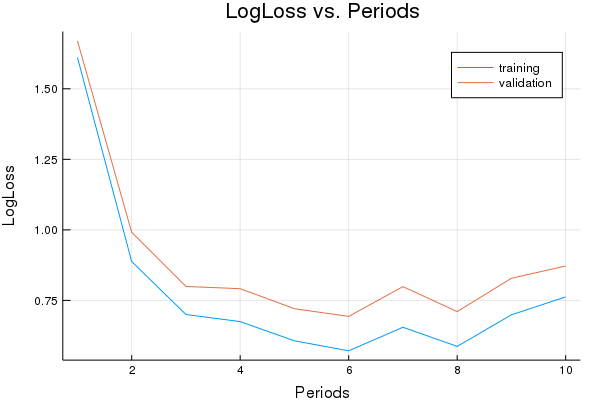

In [27]:
plot(p1)

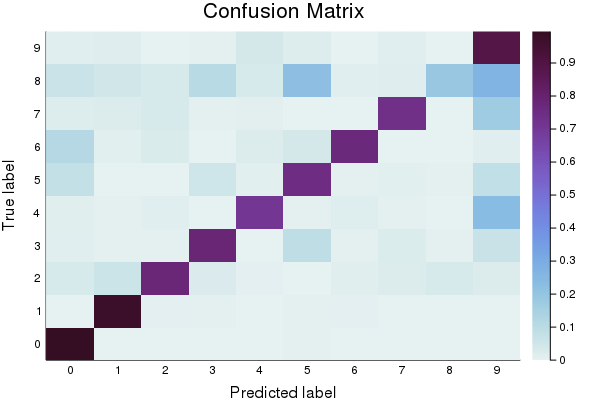

In [28]:
plot(p2)

Here is a set of parameters that should attain roughly 0.9 accuracy.

In [14]:
sess=Session(Graph())
p1, p2 = train_linear_classification_model(
    0.003,#learning rate
    1000, #steps
    30, #batch_size
    training_examples,
    training_targets,
    validation_examples,
    validation_targets)

Training model...
LogLoss error (on validation data):
  period 1: 0.6441064495787024
  period 2: 0.5319821337244007
  period 3: 0.47174609823175706
  period 4: 0.4587823813826748
  period 5: 0.43256694717421595
  period 6: 0.417219959999696
  period 7: 0.39798823667723443
  period 8: 0.4000670316113661
  period 9: 0.39256970001211594
  period 10: 0.4086718587693938
Model training finished.
Final accuracy (on validation data): 0.8908


(Plot{Plots.GRBackend() n=2}, Plot{Plots.GRBackend() n=1})

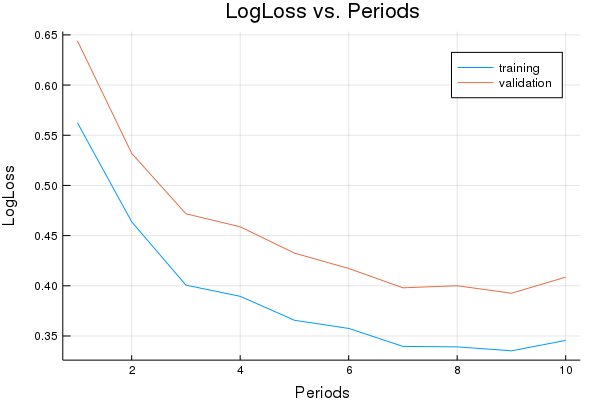

In [15]:
plot(p1)

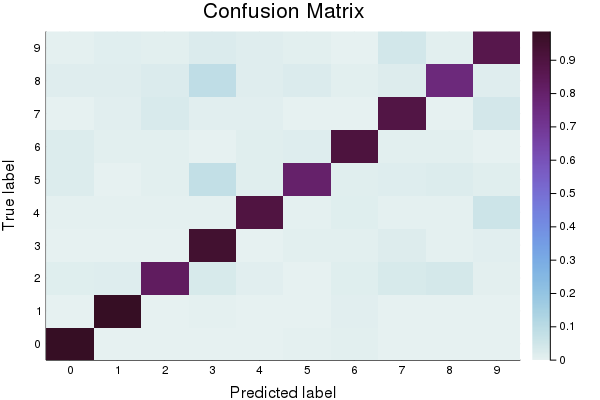

In [16]:
plot(p2)

## Task 2: Replace the Linear Classifier with a Neural Network

**Replace the LinearClassifier above with a Neural Network and find a parameter combination that gives 0.95 or better accuracy.**

You may wish to experiment with additional regularization methods, such as dropout. 

The code below is almost identical to the original `LinearClassifer` training code, with the exception of the NN-specific configuration, such as the hyperparameter for hidden units.

In [17]:
function train_nn_classification_model(learning_rate,
                     steps, 
                     batch_size, 
                     hidden_units,
                     keep_probability,
                     training_examples, 
                     training_targets, 
                     validation_examples, 
                     validation_targets)
  """Trains a NN classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, and a confusion
  matrix.
  
  Args:
    learning_rate: An `int`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A vector describing the layout of the neural network.
    keep_probability: A `float`, the probability of keeping a node active during one training step.
    training_examples: An `Array` containing the training features.
    training_targets: An `Array` containing the training labels.
    validation_examples: An `Array` containing the validation features.
    validation_targets: An `Array` containing the validation labels.
      
  Returns:
    p1: Plot of loss metrics
    p2: Plot of confusion matrix
    y: Prediction layer of the NN.
    feature_columns: Feature column tensor of the NN.
    target_columns: Target column tensor of the NN.
    weight_export: Weights of the first layer of the NN.
  """
  
  periods = 10
  steps_per_period = steps / periods

  # Create feature columns.
  feature_columns = placeholder(Float32, shape=[-1, size(training_examples,2)])
  target_columns = placeholder(Float32, shape=[-1, size(training_targets,2)])
    
  # Network parameters
  push!(hidden_units,size(training_targets,2)) #create an output node that fits to the size of the targets
  activation_functions = Vector{Function}(undef, size(hidden_units,1))
  activation_functions[1:end-1] .= z->nn.dropout(nn.relu(z), keep_probability)
  activation_functions[end] = nn.softmax #Last function should be idenity as we need the logits  
    
  # create network
  flag=0
  weight_export=Variable([1])
  Zs = [feature_columns]
  for (ii,(hlsize, actfun)) in enumerate(zip(hidden_units, activation_functions))
        Wii = get_variable("W_$ii"*randstring(4), [get_shape(Zs[end], 2), hlsize], Float32)
        bii = get_variable("b_$ii"*randstring(4), [hlsize], Float32)
        Zii = actfun(Zs[end]*Wii + bii)
        push!(Zs, Zii)
        
        if(flag==0)
            weight_export=Wii
            flag=1
        end
  end

  y=Zs[end]
  cross_entropy = reduce_mean(-reduce_sum(target_columns .* log(y), axis=[2]))
 
  # Standard Adam Optimizer
  my_optimizer=train.minimize(train.AdamOptimizer(learning_rate), cross_entropy)

  run(sess, global_variables_initializer())

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  println("Training model...")
  println("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in 1:periods
    for i=1:steps_per_period
        
    # Train the model, starting from the prior state.
    features_batches, targets_batches = next_batch(loader, batch_size)
    run(sess, my_optimizer, Dict(feature_columns=>features_batches, target_columns=>targets_batches))    
    end
  
    # Take a break and compute probabilities.
    training_predictions = run(sess, y, Dict(feature_columns=> training_examples, target_columns=>training_targets)) 
    validation_predictions = run(sess, y, Dict(feature_columns=> validation_examples, target_columns=>validation_targets))
    
    # Compute training and validation errors.
    training_log_loss = sklm.log_loss(training_targets, training_predictions)
    validation_log_loss = sklm.log_loss(validation_targets, validation_predictions)
    # Occasionally print the current loss.
    println("  period ", period, ": ",validation_log_loss)
        # Add the loss metrics from this period to our list.
    push!(training_errors, training_log_loss)
    push!(validation_errors, validation_log_loss)
  end      
        
        
  println("Model training finished.")
  
  # Calculate final predictions (not probabilities, as above).
  final_probabilities = run(sess, y, Dict(feature_columns=> validation_examples, target_columns=>validation_targets))
  
  final_predictions=0.0.*copy(final_probabilities)
  for i=1:size(final_predictions,1)
        final_predictions[i,argmax(final_probabilities[i,:])]=1.0
  end

  accuracy = sklm.accuracy_score(validation_targets, final_predictions)
  println("Final accuracy (on validation data): ", accuracy)

  # Output a graph of loss metrics over periods.
  p1=plot(training_errors, label="training", title="LogLoss vs. Periods", ylabel="LogLoss", xlabel="Periods")
  p1=plot!(validation_errors, label="validation")
  
  # Output a plot of the confusion matrix.
  cm = sklm.confusion_matrix(to1col(validation_targets), to1col(final_predictions))
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized=convert.(Float32,copy(cm))
  for i=1:size(cm,1)
     cm_normalized[i,:]=cm[i,:]./sum(cm[i,:])
  end
    
  p2 = heatmap(cm_normalized, c=:dense, title="Confusion Matrix", ylabel="True label", xlabel= "Predicted label", xticks=(1:10, 0:9), yticks=(1:10, 0:9))

  return p1, p2, y, feature_columns, target_columns, weight_export  
end

train_nn_classification_model (generic function with 1 method)

In [18]:
sess=Session(Graph())
p1, p2, y, feature_columns, target_columns, weight_export = train_nn_classification_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    0.003, #learning rate
    1000, #steps
    30, #batch_size
    [100, 100], #hidden_units
    1.0, # keep probability
    training_examples,
    training_targets,
    validation_examples,
    validation_targets)

Training model...
LogLoss error (on validation data):
  period 1: 0.7802972545112948
  period 2: 0.5114779946084309
  period 3: 0.42961612501494345
  period 4: 0.3785767363702402
  period 5: 0.3250470566823443
  period 6: 0.29775486131185236
  period 7: 0.28417328875554176
  period 8: 0.2748126428520406
  period 9: 0.23094550441845882
  period 10: 0.24898208121117577
Model training finished.
Final accuracy (on validation data): 0.9232


(Plot{Plots.GRBackend() n=2}, Plot{Plots.GRBackend() n=1}, <Tensor Softmax:1 shape=(?, 10) dtype=Float32>, <Tensor placeholder:1 shape=(?, 784) dtype=Float32>, <Tensor placeholder_2:1 shape=(?, 10) dtype=Float32>, Variable{Float32}(<Tensor W_1XNTc:1 shape=(784, 100) dtype=Float32>, <Tensor W_1XNTc/Assign:1 shape=(784, 100) dtype=Float32>))

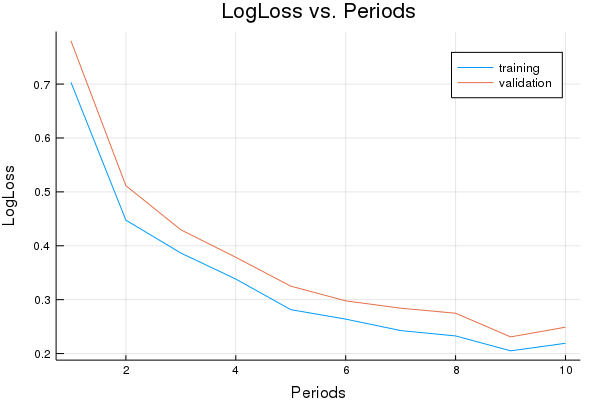

In [19]:
plot(p1)

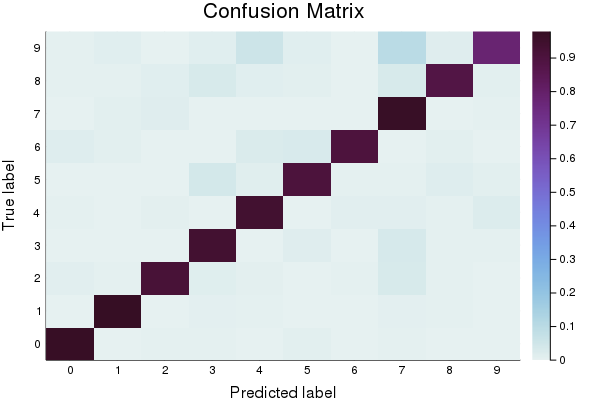

In [20]:
plot(p2)

Next, we verify the accuracy on a test set.

In [21]:
test_examples = preprocess_features(10001:13000)
test_targets = preprocess_targets(10001:13000);

In [22]:
test_probabilities = run(sess, y, Dict(feature_columns=> test_examples, target_columns=>test_targets))
  
test_predictions=0.0.*copy(test_probabilities)
for i=1:size(test_predictions,1)
    test_predictions[i,argmax(test_probabilities[i,:])]=1.0
end
  
accuracy = sklm.accuracy_score(test_targets, test_predictions)
println("Accuracy on test data: ", accuracy)

Accuracy on test data: 0.9246666666666666


## Task 3: Visualize the weights of the first hidden layer.

Let's take a few minutes to dig into our neural network and see what it has learned by accessing the `weights_export` attribute of our model.

The input layer of our model has `784` weights corresponding to the `28×28` pixel input images. The first hidden layer will have `784×N` weights where `N` is the number of nodes in that layer. We can turn those weights back into `28×28` images by *reshaping* each of the `N` `1×784` arrays of weights into `N` arrays of size `28×28`.

Run the following cell to plot the weights. We construct a function that allows us to use a string as a variable name. This allows us to automatically name all plots. We then put together a string to display everything when evaluated.

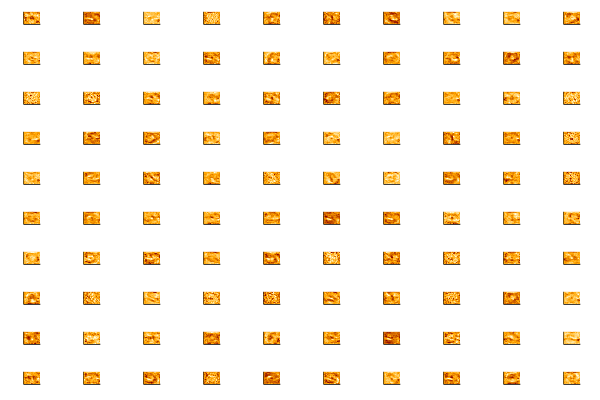

In [23]:
function string_as_varname_function(s::AbstractString, v::Any)
   s = Symbol(s)
   @eval (($s) = ($v))
end

weights0 = run(sess, weight_export)

num_nodes=size(weights0,2)
num_row=convert(Int,ceil(num_nodes/10))
for i=1:num_nodes
    str_name=string("Heat",i)
    string_as_varname_function(str_name,   heatmap(reshape(weights0[:,i], (28,28)), c=:heat, legend=false, yticks=[], xticks=[] ) )
end

out_string="plot(Heat1"
for i=2:num_nodes-1
    out_string=string(out_string, ", Heat", i)
end
    out_string=string(out_string, ", Heat", num_nodes, ", layout=(num_row, 10), legend=false )")

eval(Meta.parse(out_string))


Use the following line to have a closer look at individual plots.

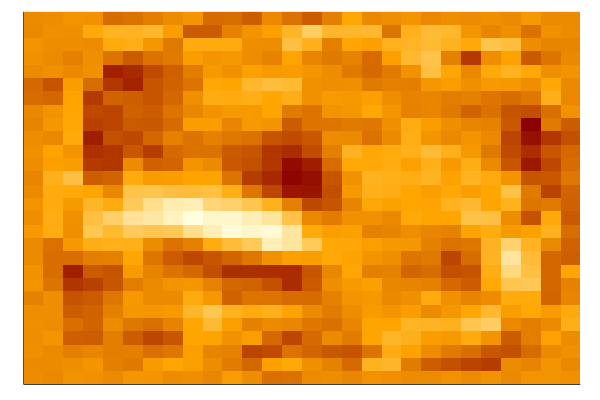

In [24]:
plot(Heat98)

The first hidden layer of the neural network should be modeling some pretty low level features, so visualizing the weights will probably just show some fuzzy blobs or possibly a few parts of digits.  You may also see some neurons that are essentially noise -- these are either unconverged or they are being ignored by higher layers.

It can be interesting to stop training at different numbers of iterations and see the effect.

**Train the classifier for 10, 100 and respectively 1000 steps. Then run this visualization again.**

What differences do you see visually for the different levels of convergence?